# Importing Data

In [166]:

from IPython.display import Markdown, display
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew

# Data visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
%matplotlib inline
plt.style.use('ggplot')

import censusgeocode as cg 
df = pd.read_csv("green_data/kc_house_data.csv")


# EDA: Data Cleaning

In [167]:
#drop rows with null values
df.dropna(subset = ['heat_source', 'sewer_system'], inplace = True)

In [168]:
#change date to datetime and split out sale year and month
df['date'] = pd.to_datetime(df['date'])
df['sale_month'] = df['date'].dt.month.astype(int)
df['sale_year'] = df['date'].dt.year.astype(int)

In [169]:
#drop rows containing addresses not in King County
        
zip_list = [98052,98115,98103,98092,98042,98023,98105,98003,98034,98118,98133,98058,98125,98031,98122,98033,98006,98032,98030,98004,98001,98059,98117,98056,98198,98168,98155,98027,98109,98002,98038,98144,98146,98074,98119,98007,98040,98029,98107,98011,98108,98072,98106,98178,98116,98112,98008,98053,98028,98126,98188,98102,98055,98075,98177,98022,98166,98199,98005,98121,98136,98045,98057,98019,98104,98077,98101,98065,98148,98070,98014,98354,98024,98051,98010,98047,98251,98134,98039,98195,98158,98068,98256,98288,98050,98132,98171,98184,98054,98009,98013,98015,98025,98035,98041,98062,98064,98063,98071,98073,98083,98089,98093,98111,98113,98114,98124,98127,98131,98129,98139,98138,98141,98145,98151,98154,98160,98164,98161,98165,98170,98174,98175,98181,98185,98190,98194,98191,98224,98471,98481]
zip_list = list(map(lambda x: str(x), zip_list))

df['in_target_area'] = df['address'].apply(lambda x: any(zip_code in x for zip_code in zip_list))
df = df.drop(df[df['in_target_area'] == False].index)

In [170]:
# Breakout city and zipcode from the address column

def residential_check(value):
    if len(value.split(',')) == 4:
        return True
    if len(value.split(',')) != 4:
        return False

df['residential'] = df['address'].apply(lambda x: residential_check(x))    
df = df.drop(df[df['residential'] == False].index)
df[['House_Num', 'City', 'State_ZIP', 'Country']] = df['address'].str.split(',', expand=True)    
df[['Empty', 'State', 'ZIP']] = df['State_ZIP'].str.split(' ', expand=True) 
df.drop(columns = ['Empty', 'in_target_area', 'residential'], inplace = True)


In [171]:
# Drop all duplicated housing IDs and addresses. Drop homes missing bed/bath data
df['id'].duplicated().value_counts()
df.drop_duplicates(subset = 'id', keep = 'first', inplace = True)


df['address'].duplicated().value_counts() 
df.sort_values(by = ['date'], ascending = False, inplace = True)
df.drop_duplicates(subset = ['address'], keep = 'first', inplace = True)

df = df[(df['bedrooms'] != 0) & (df['bathrooms'] != 0)]


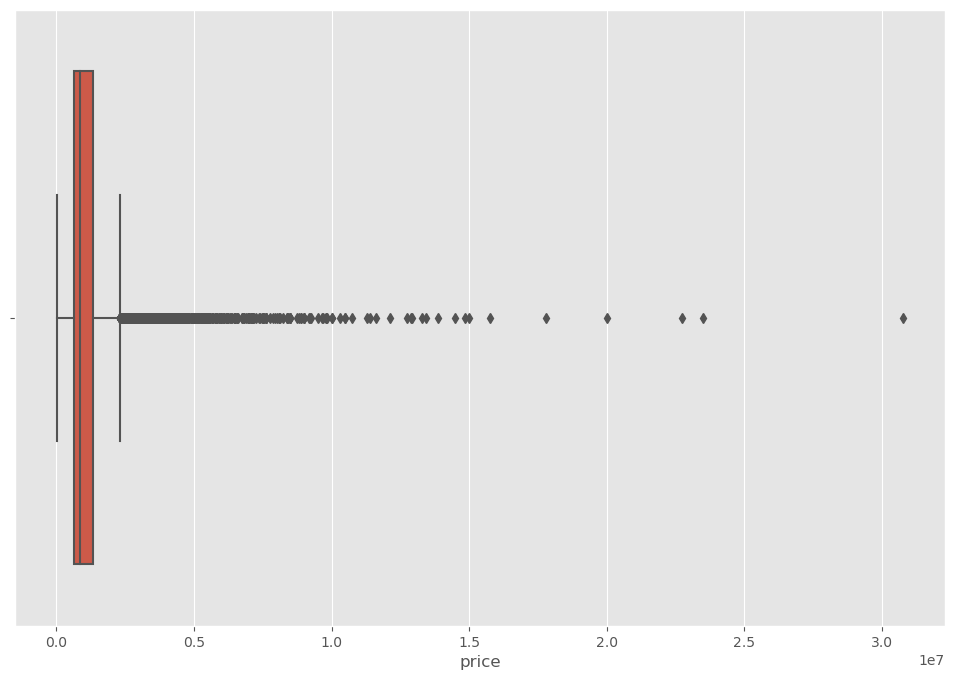

In [172]:
#Visualize price to find outliers 
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.boxplot(x = df['price'])
plt.show()

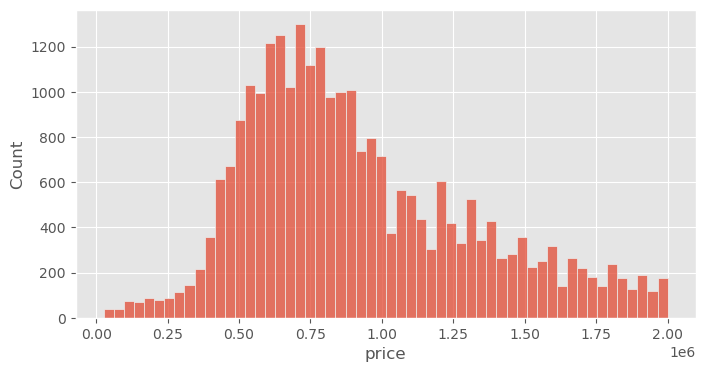

In [173]:
#removing price outliers
df = df[df["price"]<=2000000]
fig, ax = plt.subplots(figsize=(8, 4))

#making price histogram
sns.histplot(df['price'])
plt.show()

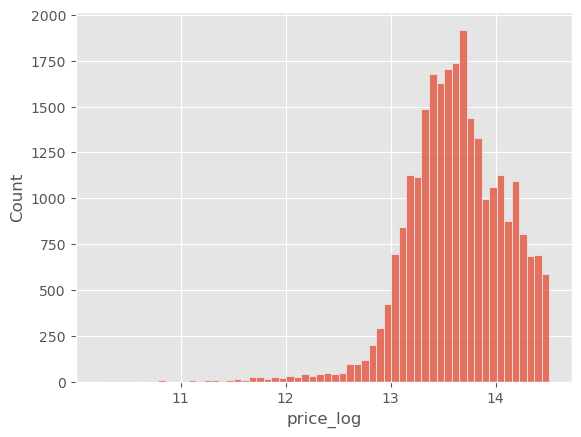

In [174]:
df["price_log"] = np.log(df["price"])

#making price histogram
sns.histplot(df["price_log"], bins = 60)
plt.show()

In [75]:
#Changing "Washington" to "WA"
df["State"] = "WA"

#Stripping City, Zip and Adress
df["City"] = df["City"].apply(lambda x: x.strip())
df["ZIP"] = df["ZIP"].apply(lambda x: x.strip())
df["House_Num"] = df["House_Num"].apply(lambda x: x.strip())

# Model 1: Adding Education Data

In [175]:
numeric_df = df.select_dtypes(exclude=['object', 'datetime'])

X = numeric_df.drop(columns=['price', 'lat', 'long', 'id'])
y = numeric_df['price_log']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)
model.score(X_test_scaled, y_test)
dict(zip(X_train.columns, model.coef_))

{'bedrooms': -7.025642643624324e-16,
 'bathrooms': 3.885780586188048e-16,
 'sqft_living': 0.0,
 'sqft_lot': -7.817097663620487e-16,
 'floors': 4.874572967494828e-16,
 'sqft_above': -5.759281940243e-16,
 'sqft_basement': 4.388850394221322e-16,
 'sqft_garage': -3.226585665316861e-16,
 'sqft_patio': 1.5872719805187785e-15,
 'yr_built': 2.723515857283587e-16,
 'yr_renovated': -1.4213890481284963e-16,
 'sale_month': -3.426078865054194e-17,
 'sale_year': 1.2923689896027213e-16,
 'price_log': 0.470750677245041}

In [76]:
school_district_map = {
    "Seattle" : "Seattle School District",
    "Renton" : "Renton School District",
    "Kent": "Kent School District",
    "Auburn": "Auburn School District",
    "Bellevue": "Bellevue School District",
    "Kirkland": "Lake Washington School District",
    "Federal Way": "Federal Way School District",
    "Redmond": "Lake Washington School District",
    "Sammamish": "Issaquah School District", 
    "Maple Valley": "Tahoma School District",
    "Shoreline": "Shoreline School District",
    "Burien": "Highline School District",
    "Woodinville": "Northshore School District",
    "Issaquah": "Issaquah School District",
    "Covington": "Kent School District",
    "North Bend": "Snoqualmie Valley School District",
    "Enumclaw": "Enumclaw School District",
    "Des Moines": "Highline School District",
    "Mercer Island": "Mercer Island School District",
    "Kenmore": "Northshore School District",
    "Snoqualmie": "Snoqualmie Valley School District",
    "Black Diamond": "Tahoma School District",
    "Bothell": "Northshore School District",
    "SeaTac": "Highline School District",
    "Duvall": "Riverview School District",
    "Lake Forest Park": "Shoreline School District",
    "Vashon": "Vashon Island School District", 
    "Newcastle": "Issaquah School District",
    "Tukwila": "Tukwila School District",
    "Carnation": "Riverview School District",
    "Normandy Park": "Highline School District", 
    "Fall City": "Snoqualmie Valley School District",
    "Pacific": "Auburn School District",
    "Ravensdale": "Tahoma School District",
    "Clyde Hill": "Bellevue School District",
    "Medina": "Bellevue School District",
    "Algona": "Auburn School District",
    "Milton": "Fife School District",
    "Skykomish": "Skykomish School District",
    "Yarrow Point": "Bellevue School District",
    "Beaux Arts": "Bellevue School District",
    "Hunts Point": "Bellevue School District",
    "Baring": "Skykomish School District",
    "Preston": "Issaquah School District",
    "Hobart": "Tahoma School District",
    "Union Hill-Novelty Hill": "Lake Washington School District",
    "Snoqualmie Pass": "Snoqualmie Valley School District",
    "Lakeland North": "Auburn School District",
    "Fairwood": "Kent School District",
    "Cottage Lake": "Northshore School District",
    "Ames Lake": "Snoqualmie Valley School District",
    "White Center": "Highline School District",
    "Dilworth": "Vashon Island School District",
}

In [77]:
school_district_data = {
    "school_district": ["Seattle School District", "Renton School District", "Kent School District", "Auburn School District", "Bellevue School District", "Lake Washington School District", "Federal Way School District", "Issaquah School District", "Tahoma School District", "Shoreline School District", "Highline School District", "Northshore School District", "Snoqualmie Valley School District", "Enumclaw School District", "Mercer Island School District", "Riverview School District", "Vashon Island School District", "Tukwila School District", "Fife School District", "Skykomish School District"],
    
    "math_scores(%)": [51.6, 32.5, 33.7, 30.2, 65.6, 70.2, 21.7, 69.6, 59.0, 55.2, 21.5, 59.6, 64.4, 40.1, 76.9, 54.7, 51.3, 16.7, 30.8, 23.8],
    
    "ela_scores(%)": [62.7, 42.9, 47.9, 43.6, 72.3, 78.5, 35.6, 76.0, 69.2, 66.6, 33.4, 72.0, 75.3, 56.7, 82.0, 69.0, 62.3, 29.6, 46.2, 71.4],
    
    "graduation_rate(%)": [88, 83, 89, 86, 94, 94, 87, 97, 94, 90, 84, 96, 96, 86, 92, 92, 94, 87, 92, 0.0],
    
    "student_expenditure($)": [18397, 16802, 16005, 16463, 17215, 14934, 16332, 15816, 14991, 15900, 17445, 15766, 15168, 15708, 16665, 15508, 16038, 18473, 15264, 58360],
    
    "kindergarten_readiness(%)": [68.3, 56.0, 47.2, 46.4, 60.0, 65.5, 46.0, 74.6, 63.1, 62.5, 55.5, 73.2, 80.6, 61.4, 78.9, 72.8, 75.0, 48.5, 48.3, 0.0],
    
}

df_school = pd.DataFrame(school_district_data)

In [78]:
#Adding school district column
df["school_district"] = df["City"].map(school_district_map)


In [79]:
#Merging school dataframe with main dataframe
df = pd.merge(df, df_school, on = "school_district")


In [80]:
#Interaction term for Education
df["score_interaction"] = df["ela_scores(%)"]*df["math_scores(%)"]*df["student_expenditure($)"]


# Model 1: Creating Base Model Education Data

/var/folders/cv/wb903gfd5v1dl5wd51qpkw480000gn/T/ipykernel_82452/3615414455.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True)


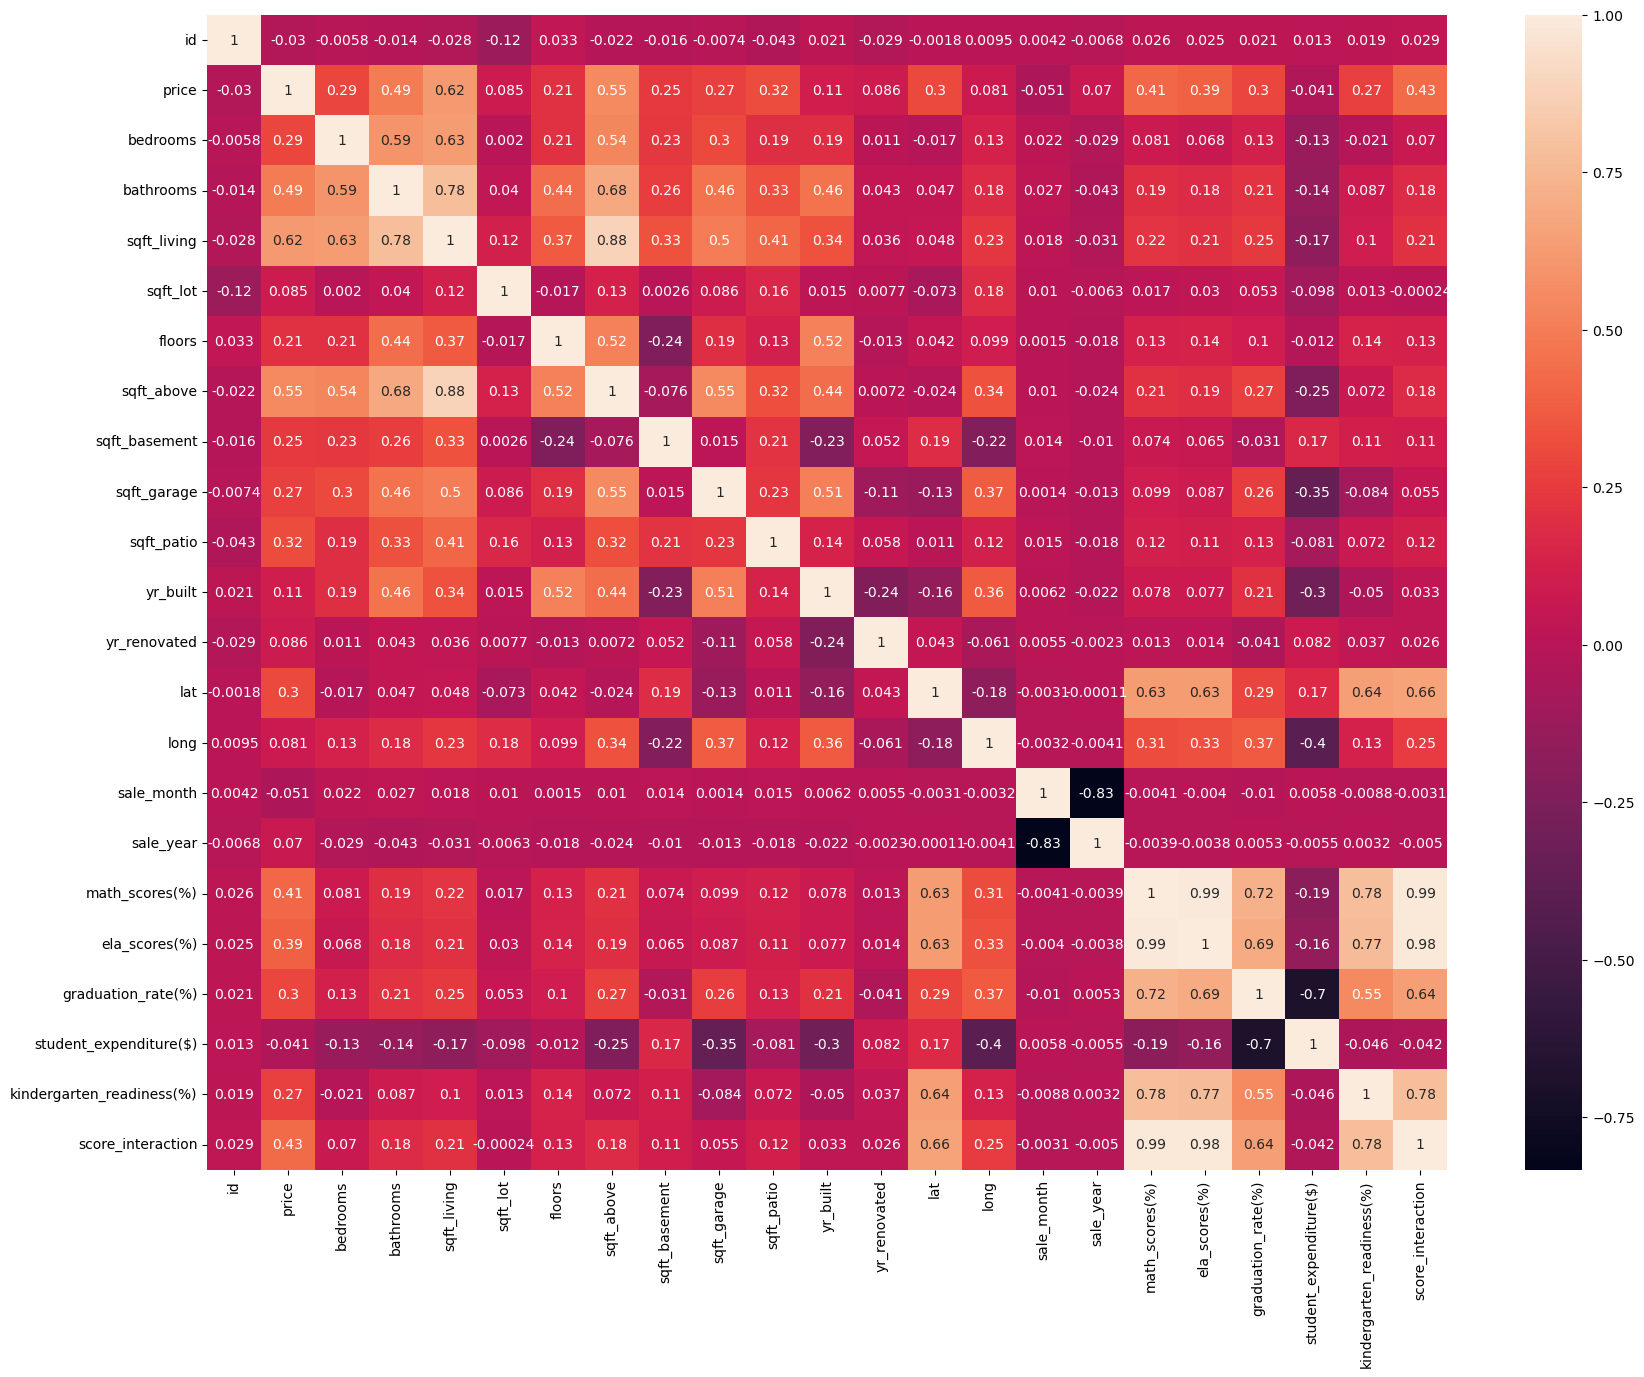

In [81]:
#Run heatmap to identify variables most correlated with price 
plt.figure(figsize=(20, 15))
sns.heatmap(df.corr(), annot = True)
plt.show();

# sqft_living most correlated with price, use as single variable base model

In [82]:
# Run train-test split to create test and control group

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
import numpy as np

X = df['sqft_living'].values.reshape(-1,1)
y = df['price'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

#baseline r-squared value is .3422 

0.33874652270567673

# Model 1: Multi-Linear using select numeric columns and standard scalar

In [83]:
numeric_df = df.select_dtypes(exclude=['object', 'datetime'])

X = numeric_df.drop(columns=['price', 'lat', 'long', 'id'])
y = numeric_df['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)
model.score(X_test_scaled, y_test)
dict(zip(X_train.columns, model.coef_))

{'bedrooms': -120680.02639255954,
 'bathrooms': 85458.07218895684,
 'sqft_living': 247267.83370858987,
 'sqft_lot': 24631.780382198915,
 'floors': -19870.433766986236,
 'sqft_above': 278603.11200466705,
 'sqft_basement': 92165.27721811837,
 'sqft_garage': -28429.376319615287,
 'sqft_patio': 29684.7310330327,
 'yr_built': -70568.76126768313,
 'yr_renovated': 23770.625560844437,
 'sale_month': 36095.11709846104,
 'sale_year': 113765.95800095252,
 'math_scores(%)': 9729.525446218373,
 'ela_scores(%)': -803567.6385991608,
 'graduation_rate(%)': -24847.172962356002,
 'student_expenditure($)': -69902.51704487977,
 'kindergarten_readiness(%)': -80331.13321336225,
 'score_interaction': 1125352.0341506642}

In [84]:
numeric_df = df.select_dtypes(exclude=['object', 'datetime'])

X = numeric_df.drop(columns=['price', 'lat', 'long', 'id'])
y = numeric_df['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_test_scaled = pd.DataFrame

In [85]:
import statsmodels.api as sm
model_OLS = sm.OLS(endog=y_train, exog=sm.add_constant(X_train_scaled)).fit()
model_OLS.summary()


# dubin watson is close to 2, which means that our errors are independent

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     1442.
Date:                Tue, 14 Feb 2023   Prob (F-statistic):               0.00
Time:                        21:59:08   Log-Likelihood:            -2.8422e+05
No. Observations:               19410   AIC:                         5.685e+05
Df Residuals:                   19390   BIC:                         5.686e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.115e+06   3974.038    280.502      0.000    1.11e+06    1.12e+06
x1         -1.207e+05   5361.104    -22.510      0.000   -1.31e+05    -1.1e+05
x2          8.546e+04   7321.880     11.672      0.000    7.11e+04    9.98e+04
x3          2.473e+05   1.78e+04     13.930      0.000    2.12e+05    2.82e+05
x4          2.463e+04   4157.681      5.924      0.000    1.65e+04    3.28e+04
x5         -1.987e+04   5756.570     -3.452      0.001   -3.12e+04   -8587.059
x6          2.786e+05   1.63e+04     17.139      0.000    2.47e+05     3.1e+05
x7          9.217e+04   8040.187     11.463      0.000    7.64e+04    1.08e+05
x8         -2.843e+04   5621.159     -5.058      0.000   -3.94e+04   -1.74e+04
x9          2.968e+04   4457.454      6.660      0.000    2.09e+04    3.84e+04
x10        -7.057e+04   6048.634    -11.667      0.000   -8.24e+04   -5.87e+04
x11         2.377e+04   4193.631      5.668      0.000    1.56e+04     3.2e+04
x12          3.61e+04   7177.841      5.029      0.000     2.2e+04    5.02e+04
x13         1.138e+05   7180.170     15.844      0.000    9.97e+04    1.28e+05
x14         9729.5254   6.95e+04      0.140      0.889   -1.26e+05    1.46e+05
x15        -8.036e+05    3.2e+04    -25.075      0.000   -8.66e+05   -7.41e+05
x16        -2.485e+04   1.11e+04     -2.230      0.026   -4.67e+04   -3011.714
x17         -6.99e+04   1.36e+04     -5.125      0.000   -9.66e+04   -4.32e+04
x18        -8.033e+04   6917.592    -11.613      0.000   -9.39e+04   -6.68e+04
x19         1.125e+06   5.59e+04     20.116      0.000    1.02e+06    1.24e+06
==============================================================================
Omnibus:                    22487.971   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5814019.793
Skew:                           5.756   Prob(JB):                         0.00
Kurtosis:                      87.002   Cond. No.                         50.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Model 2: Adding Crime Data

In [86]:
#importing crime data

crime_df = pd.read_csv("environment_data/crime.csv")
crime_df
crime_df1 = crime_df.drop(columns = ["case_number", "nibrs_code", "reporting_area", "district", "precinct", "created_at", "updated_at", "hour_of_day", "day_of_week", "ID"])


In [87]:
crime_df1["Year"] = crime_df1["incident_datetime"].apply(lambda x: x[6:10])

In [88]:
crime_df1 = crime_df1.drop(columns = ["incident_datetime"])


In [89]:
crime_df1["city"].value_counts()

SEATTLE              13523
BURIEN                8514
SHORELINE             6692
SEATAC                5531
SAMMAMISH             3195
                     ...  
WAPATO                   1
FERNDALE                 1
MEDINA                   1
BAINBRIDGE ISLAND        1
CLINTON                  1
Name: city, Length: 151, dtype: int64

In [20]:
#Checking for linearity #1
model_preds = model.predict(X_test_scaled)

resids = y_test - model_preds

fig, ax = plt.subplots()

ax.scatter(model_preds, resids)
ax.set_xlabel('predicted house prices')
ax.set_ylabel('residual')
plt.suptitle('Residuals Vs. Predictions');


TypeError: len() of unsized object

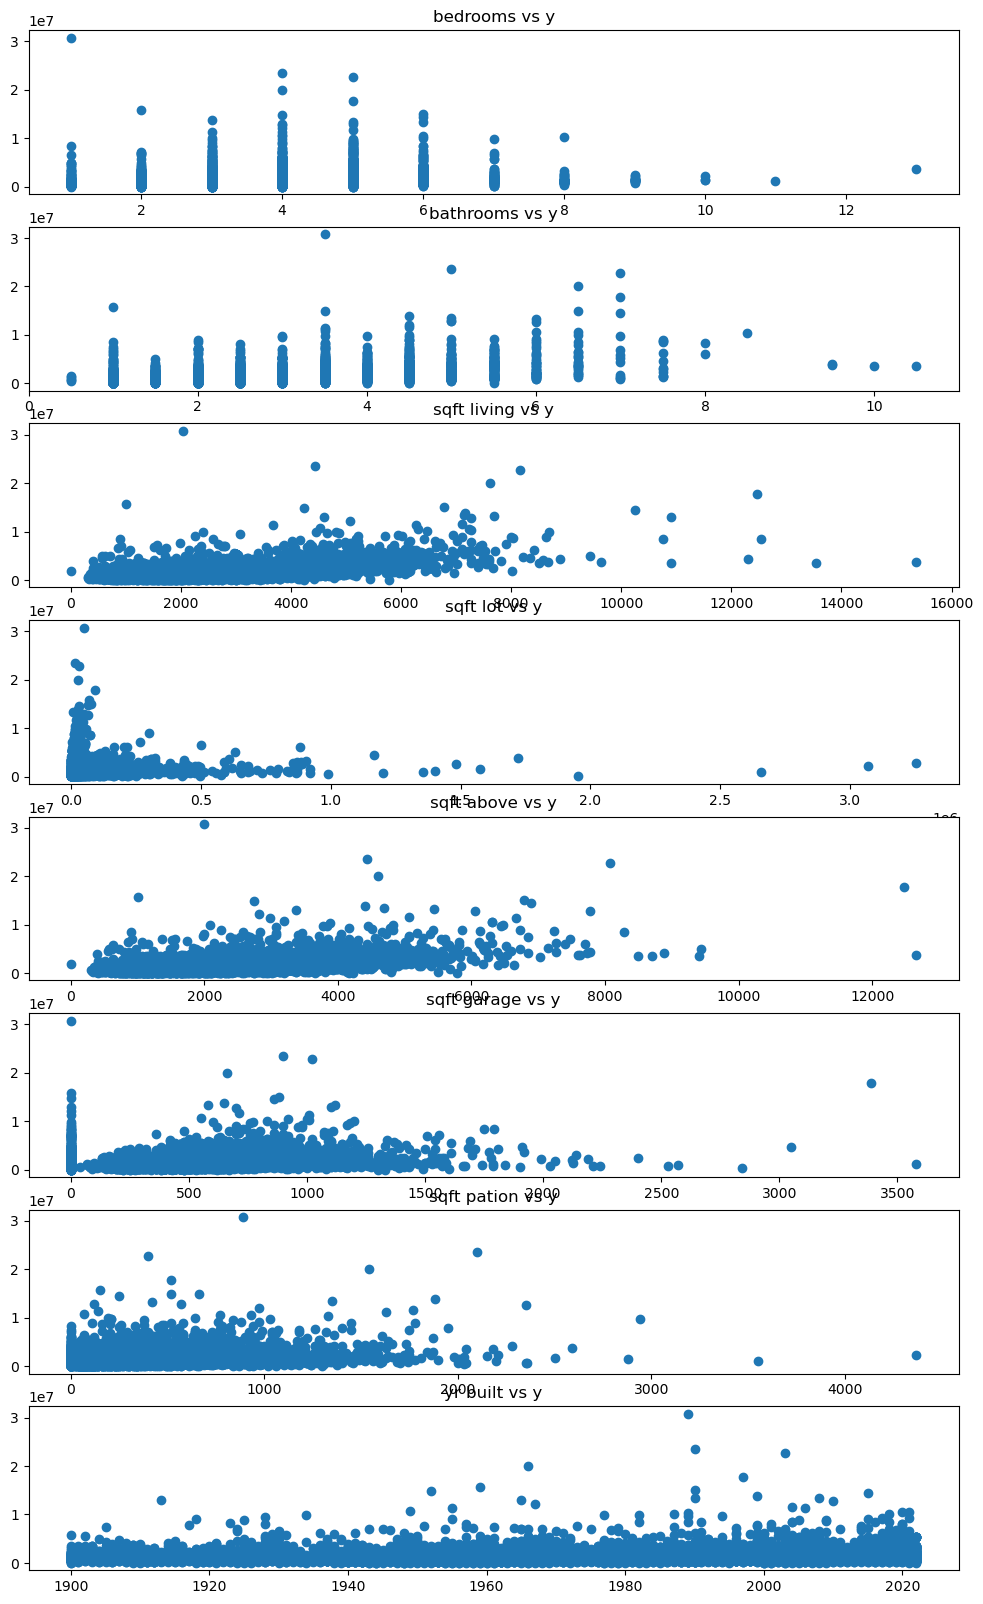

In [40]:
#Checking for linearity #2
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(nrows=8, ncols=1, figsize=(12, 20))

ax1.scatter(X['bedrooms'], y)
ax1.set_title('bedrooms vs y')
ax2.scatter(X['bathrooms'], y)
ax2.set_title('bathrooms vs y')
ax3.scatter(X['sqft_living'], y)
ax3.set_title('sqft living vs y')
ax4.scatter(X['sqft_lot'], y)
ax4.set_title('sqft lot vs y')
ax5.scatter(X['sqft_above'], y)
ax5.set_title('sqft above vs y')
ax6.scatter(X['sqft_garage'], y)
ax6.set_title('sqft garage vs y')
ax7.scatter(X['sqft_patio'], y)
ax7.set_title('sqft pation vs y')
ax8.scatter(X['yr_built'], y)
ax8.set_title('yr built vs y');


# Importing Environment Data

In [90]:
lead_df = pd.read_csv("environment_data/census_data/Lead_Risk_from_Housing(2010_census).csv")
lead_king_df = lead_df.loc[(lead_df["County Name"] == "King"), ["Census Tract", "% Units w/ Lead Hazard (Estimated)"]]
lead_king_df


,Census Tract,% Units w/ Lead Hazard (Estimated)
296,53033000100,10.24
297,53033000200,20.11
298,53033000300,25.27
299,53033000401,9.47
300,53033000402,19.95
...,...,...
688,53033032602,2.71
689,53033032702,6.57
690,53033032703,33.52
691,53033032704,10.22


In [91]:
traffic_df = pd.read_csv("environment_data/census_data/Proximity_to_Heavy_Traffic_Roadways (2010_census).csv")
traffic_king_df = traffic_df.loc[traffic_df["County Name"] == "King", ["Census Tract", "Proximity to Heavy Traffic Roadways"]]
traffic_king_df1 = traffic_king_df.drop(traffic_king_df.index[-1])
traffic_king_df1

,Census Tract,Proximity to Heavy Traffic Roadways
302,53033000100,106265.93
303,53033000200,215000.00
304,53033000300,215000.00
305,53033000401,140603.44
306,53033000402,173851.70
...,...,...
694,53033032602,67000.00
695,53033032702,67000.00
696,53033032703,65000.00
697,53033032704,49000.00


In [92]:
superfund_df = pd.read_csv("environment_data/census_data/Proximity_to_National_Priorities_List_Facilities(superfund)(2021_census).csv")
superfund_king_df = superfund_df.loc[superfund_df["County Name"] == "King", ["Census Tract", "Average PNPL"]]
superfund_king_df


,Census Tract,Average PNPL
300,53033000100,0.06
301,53033000200,0.06
302,53033000300,0.06
303,53033000401,0.06
304,53033000402,0.07
...,...,...
692,53033032602,0.06
693,53033032702,0.05
694,53033032703,0.05
695,53033032704,0.05


In [93]:
toxic_df = pd.read_csv("environment_data/census_data/Toxic_Releases_from_Facilities_(RSEI_Model)(2010_census).csv")
toxic_king_df = toxic_df.loc[toxic_df["County Name"] == "King", ["Census Tract", "Average RSEI Concentrations"]]
toxic_king_df1 = toxic_king_df.drop(toxic_king_df.index[-1])
toxic_king_df1

,Census Tract,Average RSEI Concentrations
299,53033000100,4447.00
300,53033000200,7088.62
301,53033000300,2410.15
302,53033000401,4036.39
303,53033000402,3909.42
...,...,...
691,53033032602,3191.08
692,53033032702,1271.05
693,53033032703,297.25
694,53033032704,943.36


In [94]:
smoke_df = pd.read_csv("environment_data/census_data/Wildfire_Smoke_(2010_census).csv")
smoke_king_df = smoke_df.loc[smoke_df["County Name"] == "King", ["Census Tract", "Smoke Days"]]
smoke_king_df

,Census Tract,Smoke Days
302,53033000100,6.29
303,53033000200,6.14
304,53033000300,6.14
305,53033000401,6.14
306,53033000402,6.14
...,...,...
694,53033032602,6.43
695,53033032702,6.86
696,53033032703,6.43
697,53033032704,6.29


In [95]:
environment_merge = pd.merge(lead_king_df, traffic_king_df1, on = "Census Tract")
environment_merge = pd.merge(environment_merge, superfund_king_df, on = "Census Tract")
environment_merge = pd.merge(environment_merge, toxic_king_df1, on = "Census Tract")
environment_merge = pd.merge(environment_merge, smoke_king_df, on = "Census Tract")
environment_merge

,Census Tract,% Units w/ Lead Hazard (Estimated),Proximity to Heavy Traffic Roadways,Average PNPL,Average RSEI Concentrations,Smoke Days
0,53033000100,10.24,106265.93,0.06,4447.00,6.29
1,53033000200,20.11,215000.00,0.06,7088.62,6.14
2,53033000300,25.27,215000.00,0.06,2410.15,6.14
3,53033000401,9.47,140603.44,0.06,4036.39,6.14
4,53033000402,19.95,173851.70,0.07,3909.42,6.14
...,...,...,...,...,...,...
392,53033032602,2.71,67000.00,0.06,3191.08,6.43
393,53033032702,6.57,67000.00,0.05,1271.05,6.86
394,53033032703,33.52,65000.00,0.05,297.25,6.43
395,53033032704,10.22,49000.00,0.05,943.36,6.29


In [96]:
GEO_ID = cg.address('11231 Greenwood Avenue North', city='Seattle', state='WA', zip='98133')[0]["geographies"]['Census Tracts'][0]["GEOID"]
GEO_ID

'53033001400'

In [97]:
GEO_ID = cg.address('4673 Eastern Avenue North', city='Seattle', state='WA', zip='98103')[0]["geographies"]['Census Tracts'][0]["GEOID"]
GEO_ID

'53033005100'

In [98]:
GEO_ID = cg.address('24715 232nd Place Southeast', city='Maple Valley', state='WA', zip='98038')[0]["geographies"]['Census Tracts'][0]["GEOID"]
GEO_ID

'53033032010'

In [99]:
GEO_ID = cg.address('14248 77th Avenue Northeast', city='Kirkland', state='WA', zip='98034')[0]["geographies"]['Census Tracts'][0]["GEOID"]
GEO_ID

'53033022201'

In [100]:
df["City"].value_counts()

Seattle                    9207
Renton                     1943
Kent                       1582
Auburn                     1508
Bellevue                   1480
Kirkland                   1269
Federal Way                1165
Redmond                     985
Sammamish                   975
Maple Valley                885
Shoreline                   795
Burien                      614
Woodinville                 578
Issaquah                    563
Covington                   501
North Bend                  464
Enumclaw                    455
Des Moines                  423
Mercer Island               348
Kenmore                     345
Snoqualmie                  289
Black Diamond               276
Bothell                     261
SeaTac                      252
Duvall                      245
Lake Forest Park            217
Vashon                      189
Newcastle                   187
Tukwila                     178
Carnation                   157
Fall City                   112
Normandy

In [101]:
GEO_ID = cg.address('15319 SE 178th St', city='Fairwood', state='WA', zip='98058')#[0]["geographies"]['Census Tracts'][0]["GEOID"]
GEO_ID

[{'tigerLine': {'side': 'L', 'tigerLineId': '186637076'},
  'geographies': {'States': [{'STATENS': '01779804',
     'GEOID': '53',
     'CENTLAT': '+47.4148772',
     'AREAWATER': 12548869861,
     'STATE': '53',
     'BASENAME': 'Washington',
     'STUSAB': 'WA',
     'OID': '27490225755057',
     'LSADC': '00',
     'FUNCSTAT': 'A',
     'INTPTLAT': '+47.4073238',
     'DIVISION': '9',
     'NAME': 'Washington',
     'REGION': '4',
     'OBJECTID': 20,
     'CENTLON': '-120.5954943',
     'AREALAND': 172118832362,
     'INTPTLON': '-120.5757999',
     'MTFCC': 'G4000'}],
   'County Subdivisions': [{'COUSUB': '92931',
     'GEOID': '5303392931',
     'CENTLAT': '+47.6259562',
     'AREAWATER': 67935064,
     'STATE': '53',
     'BASENAME': 'Seattle East',
     'OID': '27690836057511',
     'LSADC': '22',
     'FUNCSTAT': 'S',
     'INTPTLAT': '+47.6257726',
     'NAME': 'Seattle East CCD',
     'OBJECTID': 15696,
     'CENTLON': '-122.1312578',
     'COUSUBCC': 'Z5',
     'AREALAND': 

In [102]:
i = []
for i,row in df.iterrows(): 
    if len(cg.address(row['House_Num'], city= row['City'], state= row['State'], zip=row['ZIP'])) != 0:
        df.loc[i, 'Census_Tract']=  cg.address(row['House_Num'], city= row['City'], state= row['State'], zip=row['ZIP'])[0]["geographies"]['Census Tracts'][0]['GEOID']

        
    

KeyboardInterrupt: 

In [105]:
df["Census_Tract"].isna().value_counts()

True     24952
False     4019
Name: Census_Tract, dtype: int64

In [57]:
df.reset_index()
df["Census Tract"] = df.apply(lambda row: 'Census Tracts'][0]["GEOID"], axis = 1)


IndexError: list index out of range

# EDA

# Train/Test/Split

# Training

# Test

# Check Assumptions